In [4]:
# import libraries
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

print("Tensor: v{}".format(tf.__version__))
%matplotlib inline

Tensor: v2.12.1


In [5]:
# implement load method
def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    
    # decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    
    # convert it to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

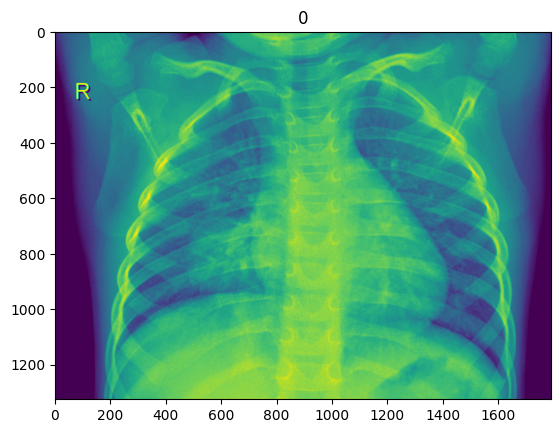

In [6]:
# load a sample of the image
image, label = load("C:/Users/infaw/Downloads/Chest Ray/chest_xray/train/PNEUMONIA/person8_bacteria_37.jpeg", 0)

fig, ax = plt.subplots()
ax.imshow(image/255.)
ax.set_title(label)
plt.show()

In [7]:
# resize the image
def resize(input_image, size):
    return tf.image.resize(input_image, size)

In [102]:
# apply a crop function to reduce the size of the image
def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[190, 190, 1])

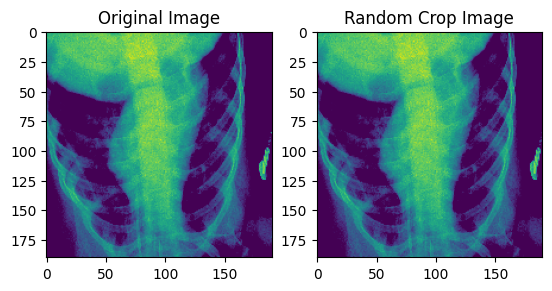

In [103]:
# view the result
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image/255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image)/255.)
ax[1].set_title("Random Crop Image")
plt.show()

In [104]:
# because random crop can crop the wrong side of the image
# centrol crop is used instead
def central_crop(input_image):
    image = resize(input_image, [224, 224])
    return tf.image.central_crop(image, central_fraction=0.84)

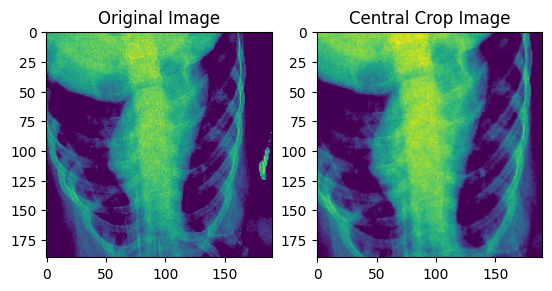

In [105]:
# view the result
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image/255.)
ax[0].set_title("Original Image")

ax[1].imshow(central_crop(image)/255.)
ax[1].set_title("Central Crop Image")
plt.show()

In [106]:
# lets implement a rotation API
def random_rotation(input_image):
    angles = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=angles[0])

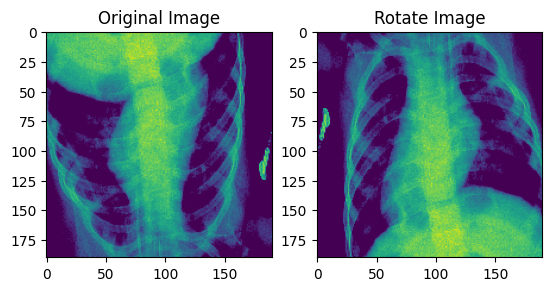

In [107]:
# view the result
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image/255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_rotation(image)/255.)
ax[1].set_title("Rotate Image")
plt.show()

In [108]:
# define a random jitter to enable other tranformation
# like random_flip_left_right
def random_jitter(input_image):
    # Resize it to 224 x 224 x 3
    image = resize(input_image, [224, 224])
    # Randomly Crop to 224 x 244 x 3
    image = random_crop(image)
    # Randomly rotation
    image = random_rotation(image)
    # Random mirroring
    image = tf.image.flip_left_right(image)
    return image

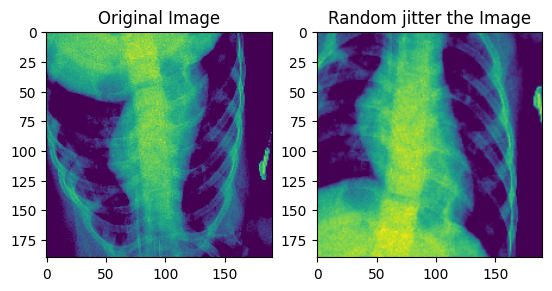

In [109]:
# view the result
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image/255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_jitter(image)/255.)
ax[1].set_title("Random jitter the Image")
plt.show()

In [110]:
# normalize the image to [-1, 1]
def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image))/2
    input_image = input_image / mid - 1
    return input_image

In [111]:
# load the train dataset
def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

# load the val dataset
def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

# load the test dataset
def load_image_test(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

In [112]:
# extract the folder name as a label and add it to the data pipeline
base_dir = "C:/Users/infaw/Downloads/Chest Ray/chest_xray/chest_xray"

normal_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'train', "NORMAL", "*.jpeg"))
normal_ds = normal_ds.map(lambda x: (x, 0))

pneumonia_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'train', "PNEUMONIA", "*.jpeg"))
pneumonia_ds = pneumonia_ds.map(lambda x: (x, 1))

# concatenate the training set
train_ds = normal_ds.concatenate(pneumonia_ds)

# Shuffle the train set and split it with batch size
buffer_size = tf.data.experimental.cardinality(train_ds).numpy()
train_ds = train_ds.shuffle(buffer_size)\
                .map(load_image_train, num_parallel_calls=16)\
                .batch(20)\
                .repeat()

In [113]:
# load the validation set
normal_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'val', "NORMAL", "*.jpeg"))
normal_ds = normal_ds.map(lambda x: (x, 0))

pneumonia_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'val', "PNEUMONIA", "*.jpeg"))
pneumonia_ds = pneumonia_ds.map(lambda x: (x, 1))

# concatenate the training set
val_ds = normal_ds.concatenate(pneumonia_ds)

val_ds = val_ds.map(load_image_val,num_parallel_calls=16)\
                .batch(20)\
                .repeat()

In [114]:
# load the test set
normal_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'test', "NORMAL", "*.jpeg"))
normal_ds = normal_ds.map(lambda x: (x, 0))

pneumonia_ds = tf.data.Dataset.list_files(os.path.join(base_dir, 'test', "PNEUMONIA", "*.jpeg"))
pneumonia_ds = pneumonia_ds.map(lambda x: (x, 1))

# concatenate the training set
test_ds = normal_ds.concatenate(pneumonia_ds)

test_ds = test_ds.map(load_image_val, num_parallel_calls=16)\
                .shuffle(buffer_size)\
                .batch(20)\
                .repeat()

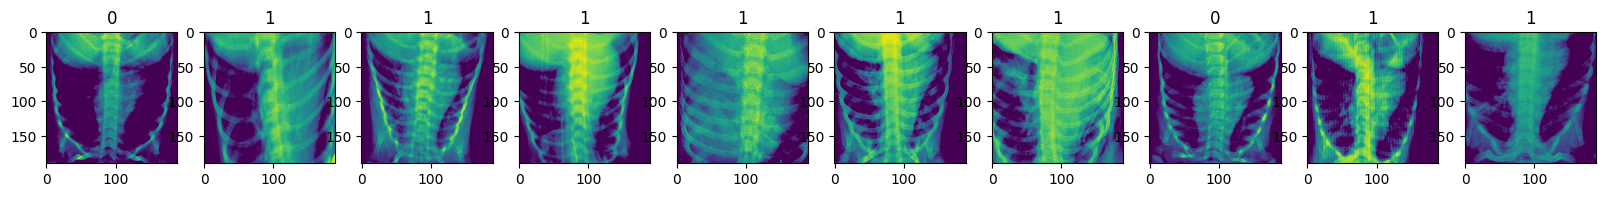

In [115]:
# check functionality of data augmenation
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 6))
    for j in range(10):
        image = images[j].numpy()
        image = image/np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
plt.show()

In [116]:
# Build the neural network
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [117]:
# Implementing CNN model with Sequential API
model = tf.keras.Sequential(name="ChestXray_CNN")

# Define the input shape (224x224x1)
model.add(Conv(filters=32, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))

# Flatten layer
model.add(tf.keras.layers.Flatten())

# Dense layers
model.add(tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))


In [118]:
model(images[:1])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.49859577, 0.5014042 ]], dtype=float32)>

In [119]:
# define a checkpoint for the training
checkpoint_path = "{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

In [120]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.summary()

Model: "ChestXray_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_20 (Conv)              (1, 94, 94, 32)           448       
                                                                 
 conv_21 (Conv)              (1, 46, 46, 64)           18752     
                                                                 
 conv_22 (Conv)              (1, 22, 22, 128)          74368     
                                                                 
 conv_23 (Conv)              (1, 10, 10, 128)          148096    
                                                                 
 flatten_5 (Flatten)         (1, 12800)                0         
                                                                 
 dense_10 (Dense)            (1, 256)                  3277056   
                                                                 
 dense_11 (Dense)            (1, 2)                  

In [121]:
# train the model
train_len = len(glob(os.path.join(base_dir, "train", 'NORMAL', "*.jpeg"))) * 2
val_len = len(glob(os.path.join(base_dir, "val", 'NORMAL', "*.jpeg"))) * 2
test_len = len(glob(os.path.join(base_dir, "test", 'NORMAL', "*.jpeg"))) * 2

In [124]:
model.fit(train_ds, steps_per_epoch= train_len/4,
         validation_data=val_ds,
         validation_steps=val_len/4,
         epochs=10,
         callbacks=[cp_callback])

Epoch 1/10
671/670 [==============================] - ETA: -1s - loss: 0.1352 - accuracy: 0.9499

TypeError: Cannot convert 0.8 to EagerTensor of dtype int64

In [101]:
# evaluate the model
model.evaluate(test_ds, steps=test_len/3)

156/156 [==============================] - 109s 645ms/step - loss: 1.3768 - accuracy: 0.6243


[1.3768415451049805, 0.6243455410003662]

In [ ]:
# visualize the performance of the model
test_batch_size = 25

for images, labels in test_ds.take(1):
    predictions = model(images)
    
images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_]